# Objective
Set-up a first big data architecture using AWS products (Mobile application with a fruit pictures classifier engine)

# Data
Link to upload data: https://www.kaggle.com/moltean/fruits

# Table of contents <a class="anchor" id="chapter0"></a> 
* [Imports and declarations](#chapter1)
    * [Import packages](#sub1_1)
    * [Declare constants](#sub1_2)
* [Exploration of the full dataset](#chapter2)
    * [Get picture information from local full dataset](#sub2_1)
    * [Explore picture information](#sub2_2)
    * [Get class information](#sub2_3) 
    * [Target label encoding](#sub2_4)
* [Preparation of the local sampled picture set](#chapter3)
    * [Create a local sampled picture set](#sub3_1)
    * [Get picture information from local sampled picture set](#sub3_2)
* [Create and configure a Spark Session](#chapter4)
* [Load data](#chapter5)
* [Features extraction](#chapter6)

* [Transfer learning](#chapter4)
    * [Instantiate a base model: ResNet50 with pre-trained weights](#sub4_1)
    * [Create a new model on top of the output of one layer from the pretrained_model](#sub4_2)
    * [Train the model on new data](#sub4_3)
* [To the stars](#chapter5)
    * [Transfer pictures from local repository to S3 bucket](#sub4_3)
    * [Read pictures examples](#sub4_3)
* [Old code](#chapter6)
    * [Cluster's descriptors](#sub3_2)
    * [Compute frequency histogram on clusters' descriptors](#sub3_3)
    * [Reduce dimension with PCA](#sub3_4)
* [Modelling](#chapter4)
    * [Train a KNN model](#sub4_1)
    * [Check learning curve](#sub4_2)
    * [Predict and compare prediction to reality on Test dataset](#sub4_3)
    * [Predict and compare prediction to reality on Validation dataset](#sub4_4)
* [Go to End](#chapter100)

# Imports and declarations <a class="anchor" id="chapter1"></a>

## Import packages <a class="anchor" id="sub1_1"></a>

In [1]:
import P8_02_module as MyMod

import numpy as np
import pandas as pd 

import os
from os import path
import glob
import shutil
import time

import matplotlib.pyplot as plt
#from matplotlib.image import imread

#from cv2 import cv2
import PIL
from PIL import Image
#, ImageDraw, ImageOps, ImageFilter

#from sklearn import cluster
#from sklearn import decomposition
#from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import learning_curve
#from sklearn.utils import shuffle

#import boto3

# Pyspark
import findspark
findspark.init("C:\spark\spark-3.2.1-bin-hadoop3.2") # Path to hadoop 
import pyspark
print("PySpark version:{}".format(pyspark.__version__)) # Verify PySpark version
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import pyarrow
print("PyArrow version:{}".format(pyarrow.__version__)) # Verify PySpark version

#from pyspark.sql.types import *
#import pyspark.sql.functions as F
#from pyspark.ml.image import ImageSchema # RDD (Resilient Distributed Dataset) from .jpg file
#from pyspark.ml.linalg import DenseVector, VectorUDT

import keras

# Tensorflow
#import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint


#, decode_predictions
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.utils import image_dataset_from_directory
#from tensorflow.keras import layers,Dense,Flatten
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.losses import BinaryCrossentropy
#from tensorflow.keras.metrics import BinaryAccuracy

PySpark version:3.2.1
PyArrow version:7.0.0


## Declare constants <a class="anchor" id="sub1_2"></a>

In [2]:
# Sample limitations
GET_PICTURES_NB_PER_CLASS = 2

# Local repositories
LOCAL_SRC_PATH = '../fruits-360-original-size/'
LOCAL_DEST_PATH = 'C:/fruits-360-sample/'

# Image size
IMAGE_RESIZE = 224

# 
BATCH_SIZE = 16
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 3

# S3 Bucket
BUCKET_NAME = "moncompartimentamoi"

# KMeans hyper-param
KMEANS_N_CLUSTERS = 90

# Exploration of the full dataset <a class="anchor" id="chapter2"></a>

## Get picture information from local full dataset <a class="anchor" id="sub2_1"></a>

In [3]:
def rep_2_picture_info(path):

    # Initiate Dataframe with Dataset names, Target class names and Picture names
    df = pd.DataFrame(columns = ['FullFileName', 'Dataset', 'Target', 'Picture', 'FileSize (in KB)']) 

    for file in glob.iglob(path+'**/*.jpg', recursive = True):

        lst = file.split('\\')

        # update DataFrame
        lst.append(os.path.getsize(file) / 1024)  # in KBytes    
        lst[0] = lst[0] + "/" + lst[1] + "/" + lst[2] + "/" + lst[3]
        df.loc[len(df)] = lst

    return df

df_main = rep_2_picture_info(LOCAL_SRC_PATH)
df_main

,FullFileName,Dataset,Target,Picture,FileSize (in KB)
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.641602
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.830078
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.173828
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.923828
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.184570
...,...,...,...,...,...
12450,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_85.jpg,39.062500
12451,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_89.jpg,40.337891
12452,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_9.jpg,33.859375
12453,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_93.jpg,39.890625


## Explore picture information <a class="anchor" id="sub2_2"></a>

### Assess volumes and modalities

In [4]:
df_main.describe()

,FileSize (in KB)
count,12455.000000
mean,45.865274
std,20.696310
min,14.218750
25%,31.997559
50%,39.761719
75%,53.937500
max,122.434570


 > 12 455 pictures, 24 target classes, 3 datasets  
 > 958 picture names mean that some pictures have the same name and are not classified in the same repository

### Count pictures by target class and dataset

In [5]:
pd.DataFrame(df_main.groupby(['Target', 'Dataset'])['Picture'].count())

Picture
Target           Dataset            
apple_6          Test            157
                 Training        315
                 Validation      158
apple_braeburn_1 Test            160
                 Training        320
...                              ...
zucchini_1       Training        160
                 Validation       80
zucchini_dark_1  Test             80
                 Training        160
                 Validation       80

[72 rows x 1 columns]

### Count pictures by target class

In [6]:
pd.DataFrame(df_main.groupby(['Target'])['Picture'].count())

,Picture
Target,
apple_6,630
apple_braeburn_1,640
apple_crimson_snow_1,636
apple_golden_1,616
apple_golden_2,616
apple_golden_3,632
apple_granny_smith_1,640
apple_hit_1,936
apple_pink_lady_1,625


### Count dataset modality by picture name

In [7]:
df_dataset_mod = pd.DataFrame(df_main.groupby(['Picture'])['Dataset'].nunique())
df_dataset_mod.rename(columns={'Dataset':'Dataset_mod'}, inplace=True)
len(df_dataset_mod[df_dataset_mod['Dataset_mod'] > 1])

0

> No file with the same name in the different datasets

### Count target class modality by picture name

In [8]:
df_target_mod = pd.DataFrame(df_main.groupby(['Picture'])['Target'].nunique())
df_target_mod.rename(columns={'Target':'Target_mod'}, inplace=True)
df_target_mod[df_target_mod['Target_mod'] > 1]

,Target_mod
Picture,
r0_0.jpg,24
r0_1.jpg,24
r0_10.jpg,24
r0_100.jpg,24
r0_101.jpg,24
...,...
r1_95.jpg,16
r1_96.jpg,16
r1_97.jpg,16


In [9]:
df_target_mod = df_target_mod.reset_index(drop=False)

In [10]:
pd.DataFrame(df_target_mod.groupby(['Target_mod'])['Picture'].count())

,Picture
Target_mod,
1,313
3,5
7,4
9,4
10,4
11,2
12,2
13,4
14,4


 > many files with the same name in the different target classes   
 > for instance, 156 files have the same name and appear in 24 different target class

In [11]:
df_main[df_main['Picture'] == 'r0_0.jpg'][['Picture', 'Target', 'Dataset']]

,Picture,Target,Dataset
3110,r0_0.jpg,apple_6,Training
3425,r0_0.jpg,apple_braeburn_1,Training
3745,r0_0.jpg,apple_crimson_snow_1,Training
4063,r0_0.jpg,apple_golden_1,Training
4371,r0_0.jpg,apple_golden_2,Training
4679,r0_0.jpg,apple_golden_3,Training
4995,r0_0.jpg,apple_granny_smith_1,Training
5315,r0_0.jpg,apple_hit_1,Training
5783,r0_0.jpg,apple_pink_lady_1,Training
6096,r0_0.jpg,apple_red_1,Training


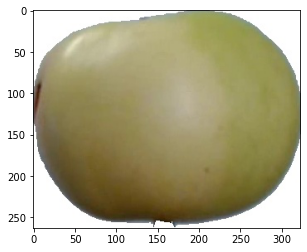

In [30]:
pict = Image.open(df_main['FullFileName'].iloc[60])
plt.imshow(pict)
plt.show()

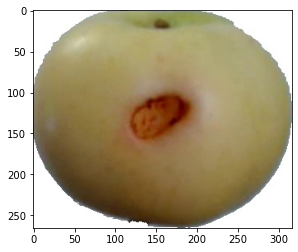

In [13]:
pict = Image.open(df_main['FullFileName'].iloc[40])
plt.imshow(pict)
plt.show()

 > File name format: r?_image_index.jpg (e.g. r0_31.jpg or r1_12.jpg)  
 > "r?" stands for rotation axis (first one is r0)

### Distinguish rotation axis and index

In [14]:
# Laurence: supprimler les FutureWarning
df_main["Rotation"], df_main["Index"] = df_main["Picture"].str.split("_", 1).str
df_main["Rotation"] = df_main["Rotation"].str.replace('r','')
df_main["Index"] = df_main["Index"].str.replace('.jpg','')
df_main

C:\Users\BNPLEA~1\AppData\Local\Temp/ipykernel_11964/3549939368.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_main["Rotation"], df_main["Index"] = df_main["Picture"].str.split("_", 1).str
C:\Users\BNPLEA~1\AppData\Local\Temp/ipykernel_11964/3549939368.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_main["Index"] = df_main["Index"].str.replace('.jpg','')


,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.641602,0,103
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.830078,0,107
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.173828,0,11
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.923828,0,111
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.184570,0,115
...,...,...,...,...,...,...,...
12450,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_85.jpg,39.062500,0,85
12451,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_89.jpg,40.337891,0,89
12452,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_9.jpg,33.859375,0,9
12453,../fruits-360-original-size/Validation/zucchin...,Validation,zucchini_dark_1,r0_93.jpg,39.890625,0,93


In [15]:
pd.DataFrame(df_main["Rotation"].unique())

,0
0,0
1,1
2,2


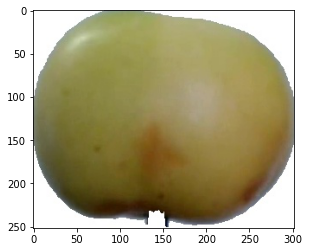

In [16]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '0'].head(1).index[0]])
plt.imshow(pict)
plt.show()

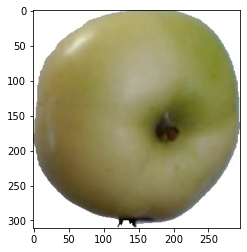

In [17]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '1'].head(1).index[0]])
plt.imshow(pict)
plt.show()

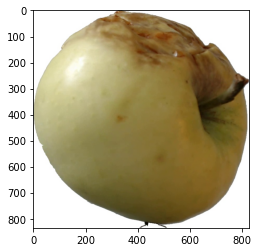

In [18]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '2'].head(1).index[0]])
plt.imshow(pict)
plt.show()

 > 0 - queue top or down > rotation around the z-axis  
 > 1 - queue behind or ahead > rotation around the x-axis  
 > 2 - queue left or right > rotation around the y-axis  

### Target class count distribution

In [19]:
def distribution(df_in, dataset):
    
    df = df_in.copy()
    
    if dataset in ['Training', 'Test', 'Validation']:
        df.drop(df[df['Dataset'] != dataset].index, inplace=True)
    elif dataset != '*':
        print("dataset argument should be 'Training', 'Test', 'Validation' or '*'")
        return -1
        
    df_distrib = pd.DataFrame(df.groupby(['Target'])['Picture'].count())
    df_distrib.reset_index(drop=False, inplace=True)
    df_distrib.rename(columns={'Picture':'Picture count', 'Target':'Class'}, inplace=True)
    df_distrib = df_distrib.sort_values(by='Class', ascending=False)    

    if len(df_distrib) == 0: return -1
    
    df_distrib.plot.barh(x='Class', y='Picture count', figsize=(12, 10))    
    
    return 1

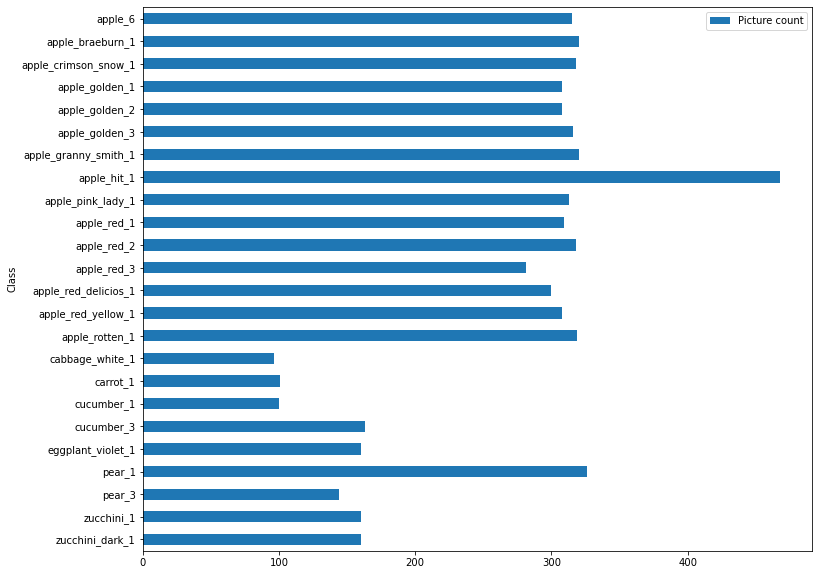

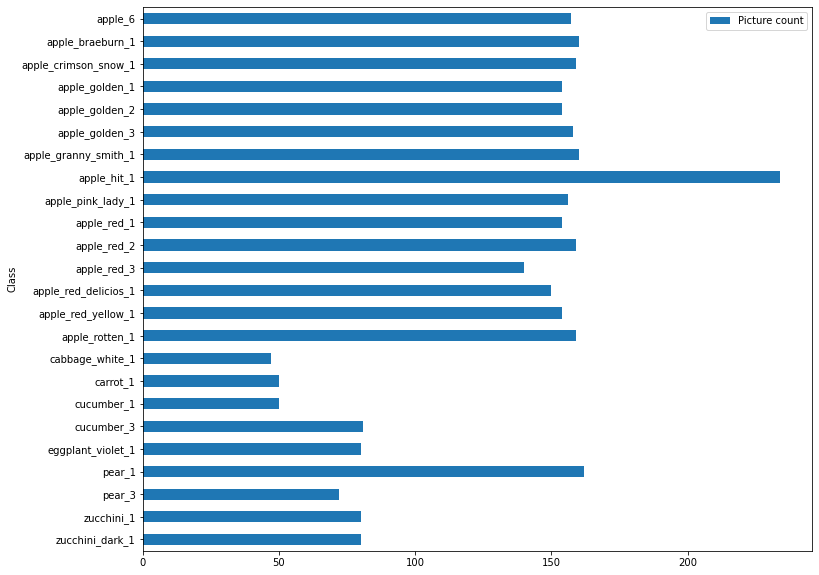

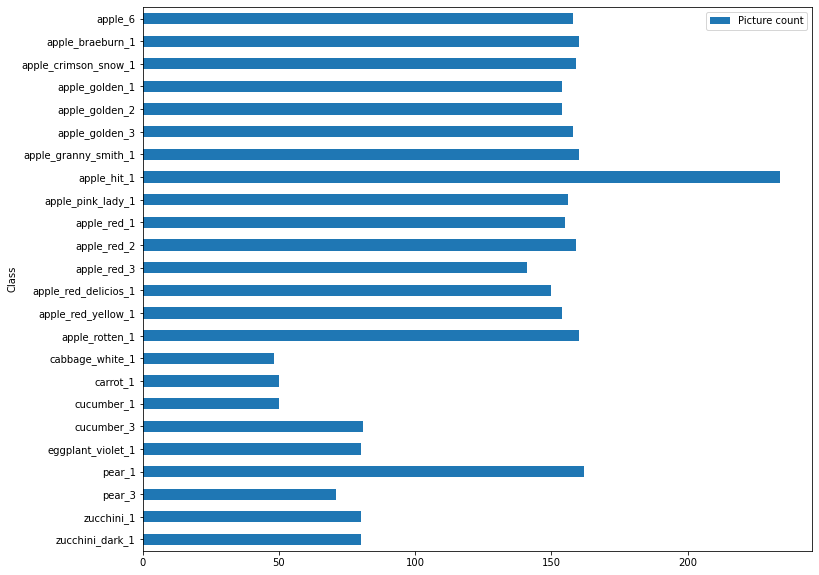

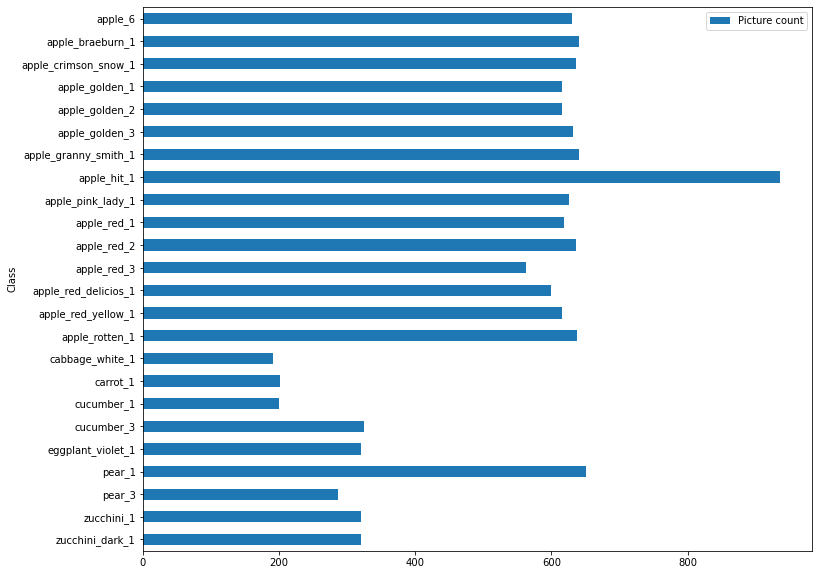

In [20]:
ret = distribution(df_main, 'Training')
ret = distribution(df_main, 'Test')
ret = distribution(df_main, 'Validation')
ret = distribution(df_main, '*')

### Target class filesize average distribution  
Logitech C920 camera and dedicated algorithm which extract the fruit from the background

In [21]:
pd.DataFrame(df_main.groupby('Target')['FileSize (in KB)'].mean())

,FileSize (in KB)
Target,
apple_6,17.398176
apple_braeburn_1,43.050488
apple_crimson_snow_1,57.663490
apple_golden_1,35.066777
apple_golden_2,31.834419
apple_golden_3,32.815130
apple_granny_smith_1,36.602792
apple_hit_1,97.034329
apple_pink_lady_1,36.341175


In [22]:
pd.DataFrame(df_main.groupby('Dataset')['FileSize (in KB)'].mean())

,FileSize (in KB)
Dataset,
Test,45.969630
Training,45.854865
Validation,45.781879


In [34]:
df_main['FileSize (in KB)'].mean(), df_main['FileSize (in KB)'].sum()/1024**2

(45.86527357863308, 0.5447883438318968)

## Get class information <a class="anchor" id="sub2_3"></a>

In [24]:
path = '../fruits-360-original-size/Meta/'

df_class_add = pd.DataFrame(columns = ['PathName', 'Target', 'TxtName'])
df_meta = pd.DataFrame(columns = ['Flag', 'Value'])

for file in glob.iglob(path+'**/info.txt', recursive = True):
    
    df_meta_add = pd.read_csv(file, sep="=", names=['Flag', 'Value'])
        
    df_class_add.loc[0] = file.split('\\')   
        
    df_meta = pd.concat([df_class_add.join(df_meta_add, how='cross'), df_meta])

del df_class_add, df_meta_add

df_meta.drop(columns=['PathName', 'TxtName'], inplace=True)
df_meta = df_meta.sort_values(['Target', 'Flag'], ascending=True)
df_meta.reset_index(drop=True, inplace=True)
df_meta

,Target,Flag,Value
0,apple_6,CLUSTERS[2],0
1,apple_6,DEFECTS[2],0
2,apple_6,FAT[3],0
3,apple_6,FRUCTOSE[3],2
4,apple_6,GROWTH LOCATION[3],2
...,...,...,...
403,zucchini_dark_1,SKIN ROUGHNESS[2],0
404,zucchini_dark_1,TYPE[5],1
405,zucchini_dark_1,VERSION,2021.09.10.0
406,zucchini_dark_1,WATER[3],2


In [25]:
df_meta['Flag'].nunique()

18

In [26]:
pd.DataFrame(df_meta['Flag'].unique(), columns=['Flag']).sort_values(by='Flag')

,Flag
0,CLUSTERS[2]
1,DEFECTS[2]
2,FAT[3]
3,FRUCTOSE[3]
4,GROWTH LOCATION[3]
5,HARDNESS[3]
6,MATURITY[3]
7,NUMBER OF SEEDS[4]
8,PROCESSED[2]
9,PURCHASED[2]


## Target label encoding  <a class="anchor" id="sub2_4"></a>

In [27]:
df_main, df_target_mapping = MyMod.encode_LabelEncoder(df_main, 'Target')
df_main.head(5)

,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index,Target_encoded
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.641602,0,103,0
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.830078,0,107,0
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.173828,0,11,0
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.923828,0,111,0
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.184570,0,115,0


In [28]:
df_meta, df_target_mapping = MyMod.encode_LabelEncoder(df_meta, 'Target')
df_meta.head(5)

,Target,Flag,Value,Target_encoded
0,apple_6,CLUSTERS[2],0,0
1,apple_6,DEFECTS[2],0,0
2,apple_6,FAT[3],0,0
3,apple_6,FRUCTOSE[3],2,0
4,apple_6,GROWTH LOCATION[3],2,0


In [29]:
df_target_mapping

,Target
Target_encoded,
0,apple_6
1,apple_braeburn_1
2,apple_crimson_snow_1
3,apple_golden_1
4,apple_golden_2
5,apple_golden_3
6,apple_granny_smith_1
7,apple_hit_1
8,apple_pink_lady_1


# Preparation of the local sampled picture set <a class="anchor" id="chapter3"></a>

## Create a local sampled picture set <a class="anchor" id="sub3_1"></a>

In [ ]:
target_prec = ""
for file in glob.iglob(LOCAL_SRC_PATH+'**/*.jpg', recursive = True):
    
    lst = file.split('\\')
    
    # Limit number of pictures per class(GET_PICTURES_NB_PER_CLASS)
    if lst[2] == target_prec: 
        i += 1
    else:
        i = 0
    target_prec = lst[2]
    
    if (lst[1] == 'Training' and i < 2*GET_PICTURES_NB_PER_CLASS) or \
                    (lst[1] != 'Training' and i < GET_PICTURES_NB_PER_CLASS):     
                
        # create the destination repository if necessary
        if not os.path.exists(LOCAL_DEST_PATH+lst[1]+"/"+lst[2]):
             os.makedirs(LOCAL_DEST_PATH+lst[1]+"/"+lst[2])

        # copy the file to the destination repository
        shutil.copyfile(LOCAL_SRC_PATH+lst[1]+"/"+lst[2]+"/"+lst[3], LOCAL_DEST_PATH+lst[1]+"/"+lst[2]+"/"+lst[3])

## Get picture information from local sampled picture set <a class="anchor" id="sub3_2"></a>

In [ ]:
df_main = rep_2_picture_info(LOCAL_DEST_PATH)
df_main

# Create and configure a Spark Session <a class="anchor" id="chapter4"></a> 
- builder()     generator to create the session
- master()      master name (yarn, mesos or local[number of cores to use]. Number of partitions for distributed objects.
- appName()     name the application
- getOrCreate() create a new session or return the existing one
- config()      configure session
    - spark.sql.repl.eagerEval.enabled: PySpark DataFrame quick assessment in Jupyter  
    - spark.sql.repl.eagerEval.maxNumRows: number of lines to show      
    - spark.sql.execution.arrow.pyspark.enabled: to use Arrow optimiser for Spark to Pandas DataFrame conversions (toPandas or createDataFrame)  

In [ ]:
# Instantiate SparkSession
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('P8_03')\
        .getOrCreate()

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)

# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [ ]:
# Get the SparkContext
sc = spark.sparkContext

In [ ]:
# User web interface
spark

# Load data <a class="anchor" id="chapter5"></a> 

## Load pictures

In [ ]:
# Fetch paths to each jpg file
lst_path = [item.replace('\\', '/') for item in list(glob.iglob(LOCAL_DEST_PATH + 'Training/**/*.jpg', recursive = True))]

### Get pictures in a Spark DataFrame in "image" format

In [ ]:
# Valentin: df_pictures = spark.read.format('image').load(LOCAL_DEST_PATH + 'Training/*', inferschema=True)

In [ ]:
# inferSchema: True to infer columns types from data
df_pictures = spark.read.format('image').load(lst_path, inferschema=True)

In [ ]:
# Spark DataFrame visualisation
df_pictures.show(5)

In [ ]:
# Spark DataFrame scheme
df_pictures.printSchema()

In [ ]:
df_pictures.select('image.origin', 'image.height', 'image.width', 'image.nChannels', 'image.mode').show(2, False, True)

### Get pictures in a Spark DataFrame in "binaryFile" format

In [ ]:
# Valentin: df_pictures = spark.read.format("binaryFile") \
#                                   .option("pathGlobFilter", "*.jpg") \
#                                   .option("recursiveFileLookup", "true").load(LOCAL_DEST_PATH + 'Training/*')

In [ ]:
df_pictures = spark.read.format("binaryFile") \
            .option("pathGlobFilter", "*.jpg") \
            .option("recursiveFileLookup", "true") \
            .load(lst_path)

In [ ]:
# Count sample size
df_pictures.count()

In [ ]:
# Spark DataFrame visualisation
df_pictures.show(5)

In [ ]:
# Spark DataFrame scheme
df_pictures.printSchema()

## Distinguish Target

In [ ]:
# Extract Target from path
df_pictures = df_pictures.withColumn('Target', element_at(split(df_pictures['path'], "/"), -2))

In [ ]:
df_pictures.show(5)

In [ ]:
# Spark DataFrame scheme
df_pictures.printSchema()

# Extract Features <a class="anchor" id="chapter6"></a> 
https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [ ]:
# Broadcast the model weights in the SparkContext
bc_model_weights = sc.broadcast(pretrained_model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    
    # set model weights to previously broadcasted weights
    model.set_weights(bc_model_weights.value)
    
    return model

## Preprocess one image

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # Redimension of pictures
    img = Image.open(io.BytesIO(content)).resize([IMAGE_RESIZE, IMAGE_RESIZE])
    
    arr = img_to_array(img)
    
    return preprocess_input(arr)

## Featurize a pd.Series of images

In [ ]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    
    preds = model.predict(input)

    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

##  Featurize all images
PandasUDFType.SCALAR_ITER used to amortize the cost of loading large models on workers  

In [ ]:
#def featurize_udf(content_series_iter: PandasUDFType.SCALAR_ITER) -> 'array<float>':
#specify type hints for pandas UDF instead of specifying pandas UDF type

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches. This amortizes the overhead of loading big models.    
    model = model_fn()
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### Fleurs

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
lst_flower_path = [item.replace('\\', '/') for item in list(glob.iglob('C:/flower_photos/**/*.jpg', recursive = True))]

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(lst_flower_path)

display(images.limit(5))

In [ ]:
features_df = images.repartition(16) \
    .select(col("path"), featurize_udf("content").alias("MyFeatures"))

In [ ]:
features_df.show()

### Apply featurization to the DataFrame of images

In [ ]:
# Save starting time
time_start = time.time()

# Large model to the full dataset
features_df = df_pictures.repartition(16) \
    .select(col("path"), col('Target'), featurize_udf("content").alias("MyFeatures"))

# Compute time elapse
elapse_s = time.time()-time_start
elapse_m = int(elapse_s / 60)
print('Feature extraction done! Time elapsed: {} seconds ({} minutes)'.format(elapse_s, elapse_m))

In [ ]:
features_df.count()

In [ ]:
#features_df.persist()
features_df.show()

# Transfer learning <a class="anchor" id="chapter4"></a> 
because my dataset has too little data to train a full-scale model from scratch  

Layers trainable attributes:
- weights : list of all weights variables of the layer  
- trainable_weights : list of those that are meant to be updated (via gradient descent) to minimize the loss during training  
- non_trainable_weights : list of those that aren't meant to be trained (updated by the model during the forward pass)  
- trainable : false moves all the layer's weights from trainable to non-trainable ("freezing" the layer)  
The only built-in layer that has non-trainable weights is the BatchNormalization layer  

Workflow 1 :  
1 - Instantiate a base model and load pre-trained weights into it  
2 - Freeze all layers in the base model by setting trainable = False  
3 - Create a new model on top of the output of one/several layers from the base model  
4 - Train your new model on your new dataset  (top layers to learn to turn the old features into predictions on a new dataset)   

Workflow 2 : feature extraction  
1 - Instantiate a base model and load pre-trained weights into it  
2 - Run your new dataset through it and record the output of one/several layers from the base model   
3 - Use that output as input data for a new, smaller model   
advantage: you only run the base model once on your data, rather than once per epoch of training > a lot faster & cheaper  
issue: doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation  

Fine-tuning (optionnal): 
unfreeze the entire/partial model you obtained and re-training it on the new data with a very low learning rate  

## Prepare my model

### Instantiate a base model: ResNet50 with pre-trained weights
"Residual Network" with 50 layers. Convolutional Neural Network

In [ ]:
pretrained_model = ResNet50(
    # Weights pre-trained on ImageNet: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 
    # in cache directory (~/.keras/models)
    weights='imagenet',                                 
    input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3),
    # Do not include the ImageNet fully-connected layer at the top of the network
    include_top=False,
    classes=24)

### Freeze all layers in the base model by setting trainable = False

In [ ]:
pretrained_model.trainable = False

### Create a new model on top of the output of one layer from the pretrained_model  

In [ ]:
# Instantiates a Keras tensor
inputs = keras.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3))

# Makes pretrained_model run in inference mode by passing training to False (necessary for fine-tuning)
x = pretrained_model(inputs, training=False)

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with 24 units et activation 'softmax'
# Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits' > logits and labels must be broadcastable
outputs = keras.layers.Dense(24, activation=DENSE_LAYER_ACTIVATION)(x)

my_model = keras.Model(inputs, outputs)

In [ ]:
# Compile
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
my_model.compile(optimizer=sgd, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)

Spark workers need to access the model and its weights.  
For moderately sized models (< 1GB in size), a good practice is to download the model to the Spark driver and 
then broadcast the weights to the workers.  
For large models (> 1GB), it is best to load the model weights from distributed storage to workers directly.  

## Train the new model

In [ ]:
def train_series(model, content_series):
    """
    Train a model a raw images
    :return: a trained model
    """
    X_train = np.stack(content_series.map(preprocess))
    y_train = content_series.col('Target')
    
    print(type(X_train))
    print(type(y_train))
    
    #cb_early_stopper = EarlyStopping(monitor = 'loss', patience = EARLY_STOP_PATIENCE)
    #cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'loss', save_best_only = True, mode = 'auto')

    #preds = model.fit(X_train, epochs=NUM_EPOCHS, callbacks=[cb_checkpointer, cb_early_stopper], y_train)

    return model

In [ ]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def train_udf(content_series_iter):

    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    
    for content_series in content_series_iter:
        yield train_series(my_model, content_series)

In [ ]:
result_df = df_pictures.repartition(16) \
    .select(col("path"), col('Target'), train_udf("content").alias("Target_Pred"))

In [ ]:
result_df.show()

# To the stars <a class="anchor" id="chapter5"></a> 

In [ ]:
# Path to hadoop 
findspark.init("C:\spark\spark-3.2.1-bin-hadoop3.2")

# Instantiate SparkSession
spark = SparkSession \
            .builder \
            .appName("Python Spark Keypoints to RDD") \
            .config("spark.some.config.option", "some-value") \
            .getOrCreate()
#spark.createDataFrame(rdd)

# Instantiate a SparkContext
sc = SparkContext()
# Verify Spark version
print("Spark version:{}".format(sc.version))

# Instantiate S3 client
s3_client = boto3.client('s3', region_name='eu-west-3')
# Instantiate S3 resource
#s3_resource = boto3.resource('s3')
# Instantiate S3 bucket
#s3_bucket = s3_resource.Bucket(BUCKET_NAME)

Though SparkContext used to be an entry point prior to 2.0, it is not completely replaced with SparkSession.
Many features of SparkContext are still available and used in Spark 2.0 and later.  
You should also know that SparkSession internally creates SparkConfig and SparkContext with the configuration provided with SparkSession.

## Transfer pictures from local repository to S3 bucket

In [ ]:
'''for file in glob.iglob(LOCAL_DEST_PATH+'**/*.jpg', recursive = True):
    # split file information
    lst = file.split('\\')
        
    # upload the image in the S3 bucket  
    s3_client.upload_file(lst[0], BUCKET_NAME, lst[1]+"/"+lst[2]+"/"+lst[3])'''

## Read pictures examples

In [ ]:
# Read pictures 1
#df = spark.read.format("image").load(LOCAL_DEST_PATH) 
#df.show()

# Read pictures 2 (ImageSchema.imageFields)
#img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())
#df = df.withColumn('vecs', img2vec("image"))
#df.show()

# Old code <a class="anchor" id="chapter6"></a> 

# Extration des descripteurs : jpg sur S3 > descripteurs

In [ ]:
def read_image_from_s3(key):
    """Load image file from s3.

    Parameters
    ----------
    key : string           Path in s3

    Returns
    -------
    np array               Image array
    """   
    #object = s3_bucket.Object(key)
    #response = object.get()
    #file_stream = response['Body']    
    #im = Image.open(file_stream)
    
    return np.array(Image.open(s3_bucket.Object(key).get()['Body']))

In [ ]:
# Create SIFT descriptor
sift = cv2.SIFT_create()
    
# Loop on .jpg pictures in AWS S3 Bucket
for obj in s3_bucket.objects.all():      # Ne prendre que les .jpg !!!!
    
    key = obj.key
    
    print(key) 
    
    if key.endswith('jpg'):        
        print(key)
        
        # Read picture from AWS S3 Bucket
        pict = np.array(Image.open(s3_bucket.Object(key).get()['Body']))

        # Compute key points and picture descriptors (descript: numpy array with one line by interest point, 128 columns)
        keypoints, descript = sift.detectAndCompute(pict, None)
        
        pd.DataFrame(descript)    

In [ ]:
#s3_url = "s3a://moncompartimentamoi/Test/apple_6/*"
s3_url = "https://moncompartimentamoi.s3.eu-west-3.amazonaws.com/Test/apple_6/r0_103.jpg"

df = spark.read.format("image").load(s3_url)

print((df.count(), len(df.columns)))
print(df.printSchema())

df.select('image.nChannels', "image.width", "image.height", "image.data").show(truncate=True)

In [ ]:
# Create PySpark RDD (Resilient Distributed Dataset)  from .jpg file
from pyspark.ml.image import ImageSchema

test = ImageSchema.readImages(s3_bucket) 
#"Training/apple_6/")

In [ ]:
def load_picture(path):
    test = ImageSchema.toNDArray(path)   
    # TypeError: image argument should be pyspark.sql.types.Row; however, it got [<class 'str'>].
    
    #test = ImageSchema.readImages(path) 
    # AttributeError: '_ImageSchema' object has no attribute 'readImages'
    
    return test

print(load_picture("Training/apple_6/"))

## Clusters' descriptors <a class="anchor" id="sub3_2"></a>

In [ ]:
# Save starting time
time_start = time.time()

# Create KMeans clustering model
kmeans = cluster.KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42) 

# Train and predict using KMeans clustering model
df_kpdesc_training = pd.concat([df_kpdesc_training, \
    pd.DataFrame(kmeans.fit_predict(df_kpdesc_training[df_kpdesc_training.columns[1:]].values), \
                 columns=['Desc_cluster'])], axis=1)

# Compute time elapse
elapse_s = time.time()-time_start
elapse_m = int(elapse_s / 60)
print('KMeans {} clusters done! Time elapsed: {} seconds ({} minutes)'.format(KMEANS_N_CLUSTERS, elapse_s, elapse_m))

# Number of iterations run et Coordinates of cluster centers
print("Case {} clusters: Converge after {} iterations"\
      .format(kmeans.cluster_centers_.shape[0], kmeans.n_iter_)) 

print()
print("Descriptor dataframe shape : ", df_kpdesc_training.shape)

df_kpdesc_training

## Compute frequency histogram on clusters' descriptors <a class="anchor" id="sub3_3"></a>
samples: pictures x features: clusters

In [ ]:
def histo_freq(df_kpdesc_training):
    
    # Use index to count
    df_kpdesc_training.reset_index(drop=False, inplace=True)
    df_kpdesc_training = df_kpdesc_training.pivot_table('index', index='FullFileName', columns='Desc_cluster', \
                                                        aggfunc='count', fill_value=0, margins=True)
    # Normalise: total for a picture is one
    for c in df_kpdesc_training.columns[:-1]:
        df_kpdesc_training[c] = df_kpdesc_training[c] / df_kpdesc_training['All']

    # Drop unusefull information
    df_kpdesc_training.drop(index='All', inplace=True)
    df_kpdesc_training.drop(columns='All', inplace=True)
    return df_kpdesc_training
    
df_kpdesc_training = histo_freq(df_kpdesc_training)    

## Reduce dimension with PCA <a class="anchor" id="sub3_4"></a>

In [ ]:
PCA_N_COMPONENTS = 0.90

# Create PCA 
pca = decomposition.PCA()

# Fit PCA
pca.fit(df_kpdesc_training.values)

# Draw explained variance absolute and cumulated
df_eboulis = MyMod.graph_eboulis_valeurspropres(pca, (18, 18), True)

print("{} clusters explain {}% of the variance"\
           .format(df_eboulis[df_eboulis['explained_variance_ratio_cum'] > PCA_N_COMPONENTS]['rang'].min(), \
                   PCA_N_COMPONENTS * 100))

In [ ]:
# Create PCA 
pca = decomposition.PCA(n_components=PCA_N_COMPONENTS)

# Fit Transform PCA
pict_features = pca.fit_transform(df_kpdesc_training.values)

print()
print("Matrix dimensions (pictures, visual words) : {}".format(pict_features.shape)) 

# Get PC coordinates in cluster space
df_contrib_PC = pd.DataFrame(pca.components_, columns=df_kpdesc_training.columns) 
df_contrib_PC.shape 

# Get the cluster best represented for each PC
#df_contrib_PC_t = df_contrib_PC.transpose()
lst_contrib = []
for i in range(pca.n_components_):     
    lst_contrib.append(df_contrib_PC.transpose()[i].idxmax(axis=0))
    
# Keep only the cluster best represented
df_kpdesc_training = df_kpdesc_training[lst_contrib]
del lst_contrib

# Unduplicate identical columns
df_kpdesc_training = df_kpdesc_training.T.groupby(level=0).first().T

df_kpdesc_training.head(5)

# Modelling <a class="anchor" id="chapter4"></a> 

## Train a KNN model <a class="anchor" id="sub4_1"></a>

In [ ]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train KNN model
X_train = df_kpdesc_training.values
y_train = df_main_training['Target_encoded'].values
knn.fit(X_train, y_train)

## Check learning curve <a class="anchor" id="sub4_2"></a>

In [ ]:
train_sizes_abs, train_scores, test_scores = learning_curve(knn, X_train, y_train, 
                                            cv=5, scoring='neg_median_absolute_error',
                                            train_sizes=np.linspace(0.1, 1, 5), 
                                            random_state=42)
plot = plt.figure(figsize=(12, 8))
plot = plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='train score')
plot = plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='validation score')
plot = plt.legend()

## Predict and compare prediction to reality on Test dataset <a class="anchor" id="sub4_3"></a>

In [ ]:
def predict_class(df, kmeans_model, pca_col_lst, knn_model):
    
    # Save starting time
    time_start = time.time()

    # Extract descriptors
    df_kpdesc = desc_extraction(df)

    # Predict clusters' descriptors with KMEANS
    df_kpdesc = pd.concat([df_kpdesc, \
        pd.DataFrame(kmeans.predict(df_kpdesc[df_kpdesc.columns[1:]].values), columns=['Desc_cluster'])], axis=1)

    # Compute histogram for main clusters
    df_kpdesc = histo_freq(df_kpdesc)    
    df_kpdesc = df_kpdesc[pca_col_lst]

    # Predict class with trained KNN
    df = pd.concat([df, pd.DataFrame(knn.predict(df_kpdesc.values), columns=['Predict'])], axis=1)

    # Compute time elapse
    elapse_s = time.time()-time_start
    elapse_m = int(elapse_s / 60)
    print('Test predictions done! Time elapsed: {} seconds ({} minutes)'.format(elapse_s, elapse_m))
    
    # Assess result ARI
    ari = metrics.adjusted_rand_score(df['Target_encoded'].values, df['Predict'].values)
    print('Test predictions done! Adjusted Rand Index: {}'.format(ari))
    
    return df

# Select Test dataset
df_main_test = df_main[df_main['Dataset'] == 'Test']

# Predict on Test dataset
df_main_test = predict_class(df_main_test, kmeans, df_kpdesc_training.columns, knn)
df_main_test.head(5)

## Predict and compare prediction to reality on Validation dataset <a class="anchor" id="sub4_4"></a>

In [ ]:
# Select Validation dataset
df_main_validation = df_main[df_main['Dataset'] == 'Validation']

# Predict on Validation dataset
df_main_validation = predict_class(df_main_validation, kmeans, df_kpdesc_training.columns, knn)
df_main_validation.head(5)

* [Go to Table des matières](#chapter0)

# End <a class="anchor" id="chapter100"></a> 

In [ ]:
'''df_main: FullFileName, Dataset, Target, Picture, FileSize (in KB), Rotation, Index, Target_encoded
df_meta: Target, Flag, Value, Target_encoded
df_target_mapping: Target_encoded, Target

df_main_training, df_main_test, df_main_validation: 
        FullFileName, Dataset, Target, Picture, FileSize (in KB), Rotation, Index, Target_encoded, Predict
df_kpdesc_training: FullFileName, Desc_cluster'''